In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

sns.set(style="ticks", font_scale=1.2, font="Arial")

# Plotting constants

In [2]:
MODEL_MAP = {
    "allenai/OLMo-7B": "OLMo 7B",
}
MODEL_ORDER = [
    "OLMo 7B"
]

# Model-related settings and helper functions.
def get_base_model(model):
    return model.split(" ")[0]
MODEL_FAMILY_ORDER = ["Pythia", "OLMo", "Gemma", "Llama-2", "Mistral"]
MODEL_FAMILY_PALETTE_NAMES = {
    model_family: pal_name
    for model_family, pal_name in zip(MODEL_FAMILY_ORDER, ["Blues", "Reds", "Greens", "Purples", "Oranges"]) 
}
MODEL_MARKERS = ["o", "v", "p", "D", "s", "^"]
def get_pretty_model_name(row):
    if row.model in MODEL_MAP:
        return MODEL_MAP[row.model]
    else:
        return row.model
def get_n_params(model_name, in_billions=True):
    n_param_str = model_name.split()[1]
    multiplier = n_param_str[-1] # "M" or "B"
    assert multiplier in ["M", "B"]
    n_params = eval(n_param_str[:-1])
    if multiplier == "M":
        if in_billions:
            return n_params * 0.001
        else:
            return n_params * 1e6
    else:
        return n_params if in_billions else n_params * 1e9
    
# Evaluation-related settings and helper functions.
EVAL_MAP = {
    "generated": "Production",
    "mc": "Forced choice",
    "direct": "Direct",
    "meta": "Metalinguistic"
}
LOW_DEMAND_COLOR = "#A7D0CD"
HIGH_DEMAND_COLOR = "#DE8971"
EVAL_PAL = [LOW_DEMAND_COLOR, HIGH_DEMAND_COLOR]
def get_eval_order(domain):
    if domain in ["crt", "digit_mat"]:
        LOW_DEMAND_METHOD = "Forced choice"
        HIGH_DEMAND_METHOD = "Production"
    elif domain in ["lambada", "syntax"]:
        LOW_DEMAND_METHOD = "Direct"
        HIGH_DEMAND_METHOD = "Metalinguistic"
    else:
        raise ValueError(f"Unknown eval order for domain={domain}")
    eval_order = [LOW_DEMAND_METHOD, HIGH_DEMAND_METHOD]
    return eval_order

def render(outpath):
    plt.savefig(f"../figures/{outpath}", bbox_inches="tight", dpi=300)
    print(f"Saved figure to ../figures/{outpath}")

# Plotting functions

In [3]:
def plot_metric_by_eval(df_long, eval_order, metric, label=None, chance=None):
    ax = sns.barplot(
        data=df_long,
        x="training_step",
        y=metric,
        hue="pretty_eval_method",
        hue_order=eval_order,
        palette=EVAL_PAL,
        err_kws={'linewidth': 1},
    )

    # Chance.
    if chance is not None:
        ax.axhline(chance, linestyle="--", color="k", alpha=0.5)

    # Legend and labels.
    ax.legend().remove()
    ax.set_xlabel("OLMo training step")
    if label is None:
        label = metric
    ax.set_ylabel(label)

    # Figure-level legend.
    handles, labels = ax.get_legend_handles_labels()
    labels = [labels[0] + " (Low task demands)", labels[1] + " (High task demands)"]
    plt.figlegend(handles[:2], labels, title="", ncol=2, loc="lower center", bbox_to_anchor=(0.5, 1), frameon=False)

    # Aesthetics.
    fig = plt.gcf()
    fig.set_size_inches(10,2.5)
    sns.despine()

In [4]:
def compute_log_odds(df_long, eval_order, metric="response_correct", ceiling=5):
    # Compute proportion correct for each model and evaluation method.
    g = df_long.groupby(["model", "training_step", "model_family", "model_n_params", "pretty_eval_method"])[metric].mean().rename("proportion_correct").to_frame().reset_index()
    # Compute log odds.
    g["odds"] = g["proportion_correct"] / (1 - g["proportion_correct"])
    g["log_odds"] = np.log(g["odds"])
    low_demand_method, high_demand_method = eval_order
    high_demand = g[g.pretty_eval_method==high_demand_method].set_index(["model", "training_step", "model_family", "model_n_params"]).log_odds
    low_demand = g[g.pretty_eval_method==low_demand_method].set_index(["model", "training_step", "model_family", "model_n_params"]).log_odds
    log_odds_diff = (low_demand - high_demand).rename("log_odds_diff").to_frame().reset_index()
    
    if ceiling is not None:
        print(f"Replacing inf with {ceiling}")
        log_odds_diff["log_odds_diff"] = log_odds_diff["log_odds_diff"].replace(np.inf, ceiling)
    return log_odds_diff

In [5]:
def plot_metric_vs_step(df, metric, label=None):
    ax = sns.lineplot(
        data=df,
        x="training_step",
        y=metric
    )
    ax = sns.scatterplot(
        data=df,
        x="training_step",
        y=metric,
        ax=ax
    )
    if label is None:
        label = metric
    ax.set_ylabel(label)
    sns.despine()
    plt.gcf().set_size_inches(4,4)
    return ax

# Digit matrices

In [6]:
def read_olmo_results(task="digit_mat"): 
    folder=f"../output/{task}"
    files = listdir(folder)
    df_wide = pd.concat([pd.read_csv(f"{folder}/{f}") for f in files if "OLMo-7B" in f])
    df_wide = df_wide[df_wide.model.isin(MODEL_MAP.keys())]
    # Set some variables.
    df_wide.model = df_wide.apply(get_pretty_model_name, axis=1)
    df_wide = df_wide[~df_wide.model.isna()]
    df_wide["model_family"] = df_wide.model.apply(get_base_model)
    df_wide["model_n_params"] = df_wide.model.apply(get_n_params, in_billions=True)
    df_wide["training_step"] = df_wide.apply(
        lambda r: int(r.revision.split("-")[0].replace("step", "")) if not pd.isna(r.revision) else 557000,
        axis=1
    )
    # Convert wide to long format.
    data_long = []
    meta_vars = ["model", "revision", "model_family", "training_step", "model_n_params", "problem_type", "problem_ind", "problem_id"]
    if task == "digit_mat":
        meta_vars += ["perm_invariant", "correct_answer"]
    else:
        meta_vars += ["prompt", "correct_answer", "foil"]
    for _, row in df_wide.iterrows():
        for eval_method in ["generated", "mc"]:
            # Copy meta-information about this stimulus item.
            res = {v: row[v] for v in meta_vars}
            # Add specific information about responses.
            res.update({
                "response": row[f"{eval_method}_response"],
                "response_sum_logprob": row[f"{eval_method}_response_sum_logprob"],
                "response_correct": row[f"{eval_method}_response_correct"],
                "eval_method": eval_method,
                "pretty_eval_method": EVAL_MAP[eval_method]
            })
            data_long.append(res)
    df_long = pd.DataFrame(data_long)
    return df_wide, df_long

domain = "digit_mat"
eval_order = get_eval_order(domain)
low_demand_method, high_demand_method = eval_order
df_wide, df_long = read_olmo_results(task=domain)
df_wide.head()

,problem_type,problem_ind,problem_id,perm_invariant,correct_answer,generated_response,generated_response_sum_logprob,generated_response_pred_set,generated_response_correct,mc_answer_logprobs,mc_response_index,mc_response,mc_response_sum_logprob,mc_response_correct,model,revision,instruct,model_family,model_n_params,training_step
0,row_constant,0,row_constant_0,False,[3],3]\n[1] [1] [,-2.441950,[3],True,"[-7.903247833251953, -6.787652969360352, -6.15...",3,3],-0.052313,True,OLMo 7B,step31000-tokens137B,False,OLMo,7,31000
1,col_constant,0,col_constant_0,False,[6],6]\n[1] [7] [,-0.398771,[6],True,"[-5.16539192199707, -4.706212997436523, -5.057...",6,6],-0.165956,True,OLMo 7B,step31000-tokens137B,False,OLMo,7,31000
2,dist3_diag1,0,dist3_diag1_0,False,[2],2]\n[2] [5] [,-3.259062,[2],True,"[-0.8843765258789062, -2.5823326110839844, -2....",0,2],-0.884377,True,OLMo 7B,step31000-tokens137B,False,OLMo,7,31000
3,dist3_diag2,0,dist3_diag2_0,False,[9],1]\n[1] [9] [,-3.154488,[1],False,"[-4.274871826171875, -3.537454605102539, -4.19...",4,1],-1.038780,False,OLMo 7B,step31000-tokens137B,False,OLMo,7,31000
4,prog_size1,0,prog_size1_0,False,[4],4]\n[3] [4] [,-1.433710,[4],True,"[-1.9254512786865234, -3.9628190994262695, -5....",4,4],-0.548306,True,OLMo 7B,step31000-tokens137B,False,OLMo,7,31000


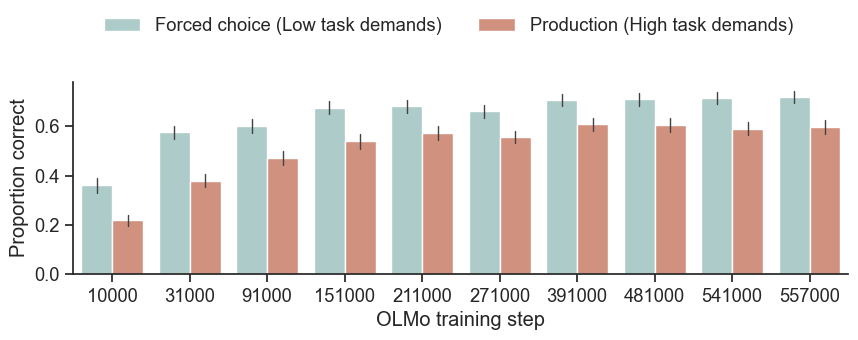

In [7]:
plot_metric_by_eval(df_long, eval_order, "response_correct", "Proportion correct")

Saved figure to ../figures/digit_mat_training_time.pdf


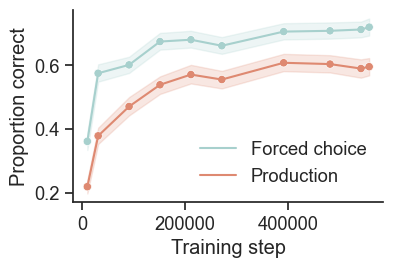

In [8]:
ax = sns.lineplot(
    data=df_long,
    x="training_step",
    y="response_correct",
    hue="pretty_eval_method",
    palette=EVAL_PAL,
    hue_order=eval_order
)
ax = sns.scatterplot(
    data=df_long.groupby(["training_step", "pretty_eval_method"])["response_correct"].mean().to_frame().reset_index(),
    x="training_step",
    y="response_correct",
    hue="pretty_eval_method",
    palette=EVAL_PAL,
    hue_order=eval_order,
    ax=ax
)
ax.set_xlabel("Training step")
ax.set_ylabel("Proportion correct")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="", frameon=False)
sns.despine()
plt.gcf().set_size_inches(4,2.5)
render(f"{domain}_training_time.pdf")

# Word prediction

In [9]:
def read_olmo_results(task="lambada"): 
    folder=f"../output/{task}"
    files = listdir(folder)
    df_wide = pd.concat([pd.read_csv(f"{folder}/{f}") for f in files if "OLMo-7B" in f])

    # Set some variables.
    df_wide["logprob_diff"] = df_wide["direct_logprob"] - df_wide["meta_logprob"]
    df_wide.model = df_wide.apply(get_pretty_model_name, axis=1)
    df_wide = df_wide[~df_wide.model.isna()]
    df_wide["model_family"] = df_wide.model.apply(get_base_model)
    df_wide["model_n_params"] = df_wide.model.apply(get_n_params, in_billions=False)
    df_wide["training_step"] = df_wide.apply(
        lambda r: int(r.revision.split("-")[0].replace("step", "")) if not pd.isna(r.revision) else 557000,
        axis=1
    )
    
    # Convert wide to long format.
    data_long = []
    meta_vars = [
        "model", "model_family", "training_step", "model_n_params", "item_id", "prefix", "final_word"
    ]
    for _, row in df_wide.iterrows():
        for eval_method in ["direct", "meta"]:
            # Copy meta-information about this stimulus item.
            res = {v: row[v] for v in meta_vars}
            # Add specific information about responses.
            res.update({
                "logprob": row[f"{eval_method}_logprob"],
                "eval_method": eval_method,
                "pretty_eval_method": EVAL_MAP[eval_method]
            })
            data_long.append(res)
    df_long = pd.DataFrame(data_long)
    return df_wide, df_long

domain = "lambada"
eval_order = get_eval_order(domain)
low_demand_method, high_demand_method = eval_order
df_wide, df_long = read_olmo_results(task=domain)
df_wide.head()

,item_id,prefix,final_word,direct_logprob,meta_logprob,kl_divergence,spearman_r_all,spearman_p_all,spearman_r_top100,spearman_p_top100,model,revision,instruct,logprob_diff,model_family,model_n_params,training_step
0,0,"In my palm is a clear stone, and inside it is ...",signs,-4.739528,-12.207016,0.000076,0.646428,0.0,0.382382,0.000086,OLMo 7B,step31000-tokens137B,False,7.467488,OLMo,7.000000e+09,31000
1,1,Give me a minute to change and I'll meet you a...,Shane,-4.445111,-2.792581,0.000047,0.844331,0.0,0.289061,0.003536,OLMo 7B,step31000-tokens137B,False,-1.652531,OLMo,7.000000e+09,31000
2,2,"""Only one source I know of that would be likel...",insurance,-0.837069,-9.087311,0.000142,0.571935,0.0,0.091365,0.365965,OLMo 7B,step31000-tokens137B,False,8.250242,OLMo,7.000000e+09,31000
3,3,Helen's heart broke a little in the face of Mi...,Helen,-1.173895,-1.462021,0.000036,0.797996,0.0,0.364116,0.000196,OLMo 7B,step31000-tokens137B,False,0.288126,OLMo,7.000000e+09,31000
4,4,Preston had been the last person to wear those...,chains,-2.047471,-9.223774,0.000110,0.630814,0.0,0.160924,0.109720,OLMo 7B,step31000-tokens137B,False,7.176303,OLMo,7.000000e+09,31000


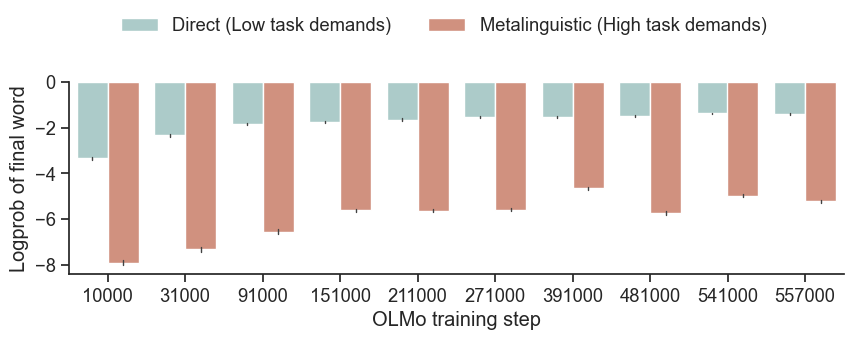

In [10]:
plot_metric_by_eval(df_long, eval_order, "logprob", "Logprob of final word")

Saved figure to ../figures/lambada_training_time.pdf


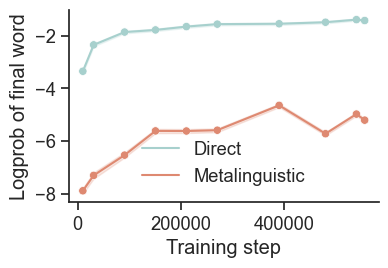

In [11]:
metric = "logprob"
label = "Logprob of final word"
ax = sns.lineplot(
    data=df_long,
    x="training_step",
    y=metric,
    hue="pretty_eval_method",
    palette=EVAL_PAL,
    hue_order=eval_order
)
ax = sns.scatterplot(
    data=df_long.groupby(["training_step", "pretty_eval_method"])[metric].mean().to_frame().reset_index(),
    x="training_step",
    y=metric,
    hue="pretty_eval_method",
    palette=EVAL_PAL,
    hue_order=eval_order,
    ax=ax
)
ax.set_xlabel("Training step")
ax.set_ylabel(label)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="", frameon=False)
sns.despine()
plt.gcf().set_size_inches(4,2.5)
render(f"{domain}_training_time.pdf")